In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

In [2]:
df = pd.read_csv("nifty_intraday_15m.csv")
df.head()

,Datetime,Close,High,Low,Open,Volume,date,time
0,NaN,NIFTYBEES.NS,NIFTYBEES.NS,NIFTYBEES.NS,NIFTYBEES.NS,NIFTYBEES.NS,NaN,NaN
1,2025-05-19 03:45:00+00:00,280.07000732421875,280.67999267578125,279.6099853515625,280.2099914550781,275073,2025-05-19,03:45:00
2,2025-05-19 04:00:00+00:00,279.9700012207031,280.5400085449219,279.7099914550781,280.1000061035156,314377,2025-05-19,04:00:00
3,2025-05-19 04:15:00+00:00,280.010009765625,280.239990234375,279.9100036621094,280.0,162601,2025-05-19,04:15:00
4,2025-05-19 04:30:00+00:00,280.45001220703125,280.4700012207031,280.0400085449219,280.1000061035156,161882,2025-05-19,04:30:00


In [3]:
if df.iloc[0].astype(str).str.contains("NIFTYBEES", case=False).any():
    df = df.iloc[1:]

In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_convert('Asia/Kolkata')
df['date'] = pd.to_datetime(df['date'])
df['time'] = df['Datetime'].dt.time
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

In [5]:
print("\nMissing values per column:")
print(df.isnull().sum())

#df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])


Missing values per column:
Datetime    0
Close       0
High        0
Low         0
Open        0
Volume      0
date        0
time        0
dtype: int64


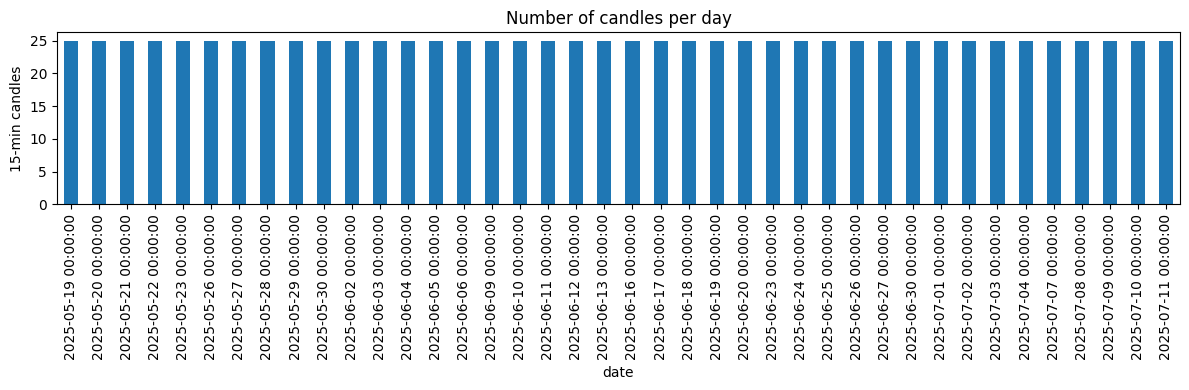

In [6]:
daily_counts = df['date'].value_counts().sort_index()
daily_counts.plot(kind='bar', figsize=(12, 4), title='Number of candles per day')
plt.ylabel("15-min candles")
plt.tight_layout()
plt.show()

In [7]:
# 1. Remove rows with 0 or negative prices
df = df[(df[['Open', 'High', 'Low', 'Close']] > 0).all(axis=1)]

# 2. Ensure High >= Low
df = df[df['High'] >= df['Low']]

# 3. Drop outlier high-low spreads
df['hl_spread'] = df['High'] - df['Low']
df = df[df['hl_spread'] < df['hl_spread'].quantile(0.999)]

# 4. Remove volume spikes
df = df[df['Volume'] < df['Volume'].quantile(0.999)]

# 5. Drop duplicate timestamps
df = df.drop_duplicates(subset='Datetime')

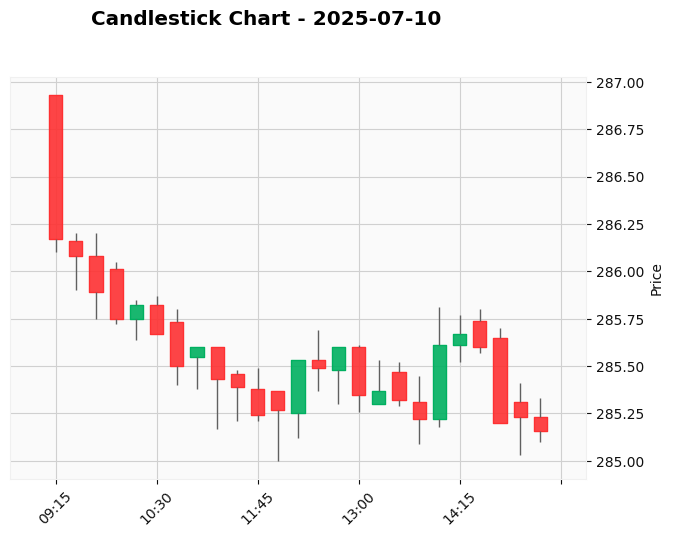

In [8]:
sample_day = df[df['date'] == pd.to_datetime('2025-07-10')]  # example date
if not sample_day.empty:
    sample_day_plot = sample_day.set_index('Datetime')[['Open', 'High', 'Low', 'Close']]
    mpf.plot(sample_day_plot, type='candle', style='yahoo', title="Candlestick Chart - 2025-07-10")

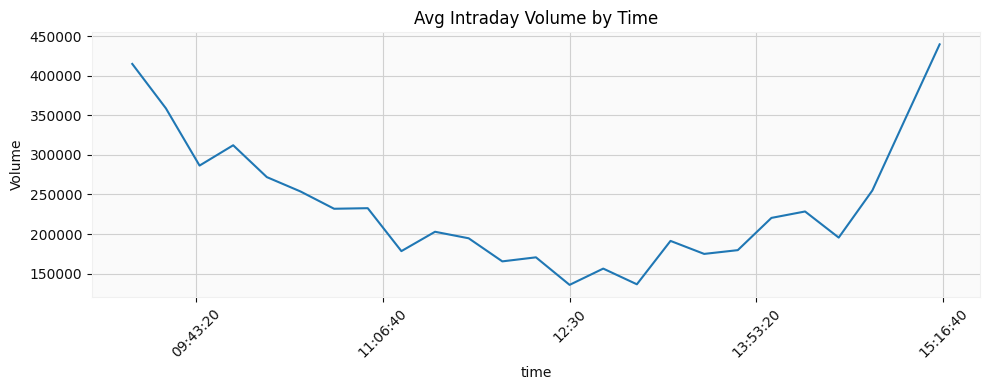

In [9]:
volume_by_time = df.groupby('time')['Volume'].mean()
volume_by_time.plot(figsize=(10,4), title='Avg Intraday Volume by Time')
plt.xticks(rotation=45)
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
df.drop(columns=['hl_spread'], inplace=True)
df.to_csv("nifty_intraday_15m_cleaned.csv", index=False)
print("Cleaned data saved nifty_intraday_15m_cleaned.csv")

Cleaned data saved nifty_intraday_15m_cleaned.csv


In [11]:
df['weekday'] = pd.to_datetime(df['date']).dt.weekday
expiry_days = df[df['weekday'] == 3]['date'].unique()  # Thursday = 3
print("Expiry (Thursday) dates in data:", expiry_days)

for day in expiry_days:
    times = df[df['date'] == pd.to_datetime(day)]['time'].astype(str).unique()
    print(f"{day} → Times: {sorted(times)}")

Expiry (Thursday) dates in data: <DatetimeArray>
['2025-05-22 00:00:00', '2025-05-29 00:00:00', '2025-06-05 00:00:00',
 '2025-06-12 00:00:00', '2025-06-19 00:00:00', '2025-06-26 00:00:00',
 '2025-07-03 00:00:00', '2025-07-10 00:00:00']
Length: 8, dtype: datetime64[ns]
2025-05-22 00:00:00 → Times: ['09:15:00', '09:30:00', '09:45:00', '10:00:00', '10:15:00', '10:30:00', '10:45:00', '11:00:00', '11:15:00', '11:30:00', '11:45:00', '12:00:00', '12:15:00', '12:30:00', '12:45:00', '13:00:00', '13:15:00', '13:30:00', '13:45:00', '14:00:00', '14:15:00', '14:30:00', '14:45:00', '15:00:00', '15:15:00']
2025-05-29 00:00:00 → Times: ['09:15:00', '09:30:00', '09:45:00', '10:00:00', '10:15:00', '10:30:00', '10:45:00', '11:00:00', '11:15:00', '11:30:00', '11:45:00', '12:00:00', '12:15:00', '12:30:00', '12:45:00', '13:00:00', '13:15:00', '13:30:00', '13:45:00', '14:00:00', '14:15:00', '14:30:00', '14:45:00', '15:00:00', '15:15:00']
2025-06-05 00:00:00 → Times: ['09:15:00', '09:30:00', '09:45:00', '10:0

In [12]:
for day in expiry_days:
    prev_day = pd.to_datetime(day) - pd.Timedelta(days=1)
    
    prev_close = df[df['date'] == prev_day].sort_values('Datetime')['Close'].iloc[-1] if not df[df['date'] == prev_day].empty else None
    entry_price = df[(df['date'] == pd.to_datetime(day)) & (df['time'].astype(str) == "09:30:00")]['Close']
    
    if prev_close is not None and not entry_price.empty:
        move = (entry_price.iloc[0] - prev_close) / prev_close
        print(f"{day}: Prev Close = {prev_close:.2f}, Entry = {entry_price.iloc[0]:.2f}, Move = {move*100:.2f}%")


2025-05-22 00:00:00: Prev Close = 277.49, Entry = 275.55, Move = -0.70%
2025-05-29 00:00:00: Prev Close = 277.79, Entry = 278.29, Move = 0.18%
2025-06-05 00:00:00: Prev Close = 276.40, Entry = 277.64, Move = 0.45%
2025-06-12 00:00:00: Prev Close = 281.76, Entry = 281.59, Move = -0.06%
2025-06-19 00:00:00: Prev Close = 278.31, Entry = 278.75, Move = 0.16%
2025-06-26 00:00:00: Prev Close = 283.33, Entry = 284.45, Move = 0.40%
2025-07-03 00:00:00: Prev Close = 285.89, Entry = 286.25, Move = 0.13%
2025-07-10 00:00:00: Prev Close = 286.56, Entry = 286.08, Move = -0.17%
